# Simulations - 1 

In [1]:
library(repr)
options(repr.plot.width=12, repr.plot.height=6, repr.plot.res = 80, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
library(maxLik)
set.seed(0)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: MASS
Loading required package: MatchIt
Loading required package: nnet
Loading required package: numDeriv
CBPS: Covariate Balancing Propensity Score
Version: 0.10
Authors: Christian Fong <christianfong@stanford.edu>, Marc Ratkovic <ratkovic@princeton.edu>, Chad Hazlett <chazlett@ucla.edu>, Kosuke Imai <kimai@princeton.edu>

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve

Loading required package: miscTools

Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/

Attaching packag

In [2]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.iters <- 100

offset = 0.1
lambda = 1
q = 0.6

# Пробуем функцию мешалкина

    Попробовать при разных смещениях!!!

In [3]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)

In [4]:
MeshalkinLoss <- function(u, offset=1) {
    offset = offset / 5
    return  (1 - exp(-u**2 / offset ))
}
MeshalkinLoss.grad  <- function(u, offset=1) {
    offset = offset / 5
    return (2 * u / offset * exp(-u**2 / offset))
}
MeshalkinLoss.hess <- function(u, offset=1) {
    offset = offset / 5
    return (2 / offset * exp(-u**2 / offset) * (1 - 2 * u ** 2 / offset))
}

# WARN: Using only 
# TODO: Decide what to use here: reward or raw reward ? 
MeshalkinObjFunc <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- MeshalkinLoss(deviance, offset = offset)
    return(mean(obs.data$reward * loss / obs.data$prop.scores / offset)  + lambda_reg * params %*% params )
}

MeshalkinObjFunc.grad <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- MeshalkinLoss.grad(deviance, offset = offset)
    obj.func.coefs <- obs.data$reward * loss / obs.data$prop.scores / offset 
    obj.func.value <-  colMeans(Diagonal(n=NROW(obj.func.coefs), x=obj.func.coefs) %*% (-obs.data$covariates))
    return(obj.func.value  + 2 * lambda_reg * params)
}


MeshalkinObjFunc.hess <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- MeshalkinLoss.hess(deviance, offset = offset)
    obj.func.matrix <- obs.data$reward * loss / obs.data$prop.scores / offset
    n <- length(obs.data$reward)
    acc <- 0 
    for (i in seq(1, n)) {
        acc <- acc + obj.func.matrix[i] * obs.data$covariates[i, ] %o% obs.data$covariates[i, ] 
    }
    return(acc / n  + 2 * lambda_reg * diag(NCOL(obs.data$covariates)))
}

MeshalkinObjFunc.2max <- function(...) {- MeshalkinObjFunc(...)}
MeshalkinObjFunc.grad.2max <- function(...) {- MeshalkinObjFunc.grad(...)}
MeshalkinObjFunc.hess.2max <- function(...) {- MeshalkinObjFunc.hess(...)}


NROptimizeMeshalkinGain <- function (params, obs.data,  offset, policy.function, lambda, 
                                   hyperparams=list(), opt.hyperparams=list()) {
    default.list <- list(use.hessian=TRUE)
    opt.hyperparams <- modifyList(default.list, opt.hyperparams)
    if (opt.hyperparams$use.hessian) {
        res <- maxNR(MeshalkinObjFunc.2max, grad=MeshalkinObjFunc.grad.2max, start=opt.hyperparams$init.pars, 
                     obs.data=train,  offset=offset, policy.function=policy.function, lambda_reg=lambda) 
    } else {
        res <- maxNR(MeshalkinObjFunc.2max, grad=MeshalkinObjFunc.grad.2max, hess=MeshalkinObjFunc.hess.2max, 
                     start=opt.hyperparams$init.pars, 
                     obs.data=train,  offset=offset, policy.function=policy.function, lambda_reg=lambda) 
    }
    cat("Code: ", res$code, " Message: ", res$message, "\n")
    return (res$estimate)
} 



In [5]:
res <- maxNR( MeshalkinObjFunc.2max, grad=MeshalkinObjFunc.grad.2max, 
#       hess=MeshalkinObjFunc.hess, 
      start=GetInitPars(train), 
      obs.data=train,  offset=offset, policy.function=PolicyFunLinearKernel, lambda_reg=lambda) 

res.with.hessian <- maxNR( MeshalkinObjFunc.2max, grad=MeshalkinObjFunc.grad.2max, 
      hess=MeshalkinObjFunc.hess.2max, 
      start=GetInitPars(train), 
      obs.data=train,  offset=offset, policy.function=PolicyFunLinearKernel, lambda_reg=lambda) 

res.with.hessian.change <- maxNR( MeshalkinObjFunc.2max, grad=MeshalkinObjFunc.grad.2max, 
      hess=MeshalkinObjFunc.hess.2max, 
      start=GetInitPars(train, q=0.7), 
      obs.data=train,  offset=offset, policy.function=PolicyFunLinearKernel, lambda_reg=lambda) 

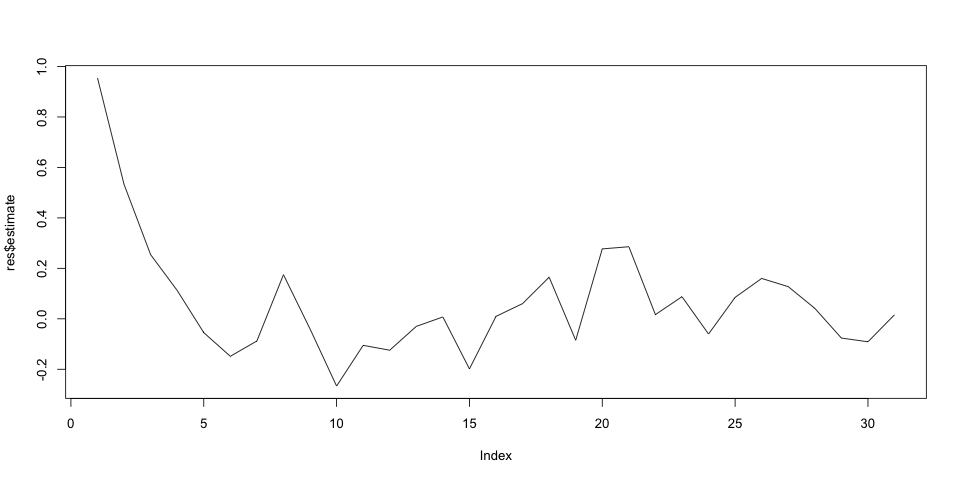

In [7]:
plot(res$estimate, type="l")
# lines(GetInitPars(train), col="yellow", type="l")
# lines(res.with.hessian$estimate, col="red", type="l")
# lines(res.with.hessian.change$estimate, col="green", type="l")

In [8]:
offset = 0.1

In [9]:
opt.params = list("opt.func"=NROptimizeMeshalkinGain, "init.pars"=GetInitPars(train, q=q), "use.hessian"=TRUE)
res <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)

Code:  1  Message:  gradient close to zero 


In [11]:

plot (x,y)

dev.copy(jpeg,filename="plot.jpg");
dev.off ();

ERROR: Error in plot(x, y): error in evaluating the argument 'x' in selecting a method for function 'plot': Error: object 'x' not found



quartz_off_screen 
                3

pdf 
  2

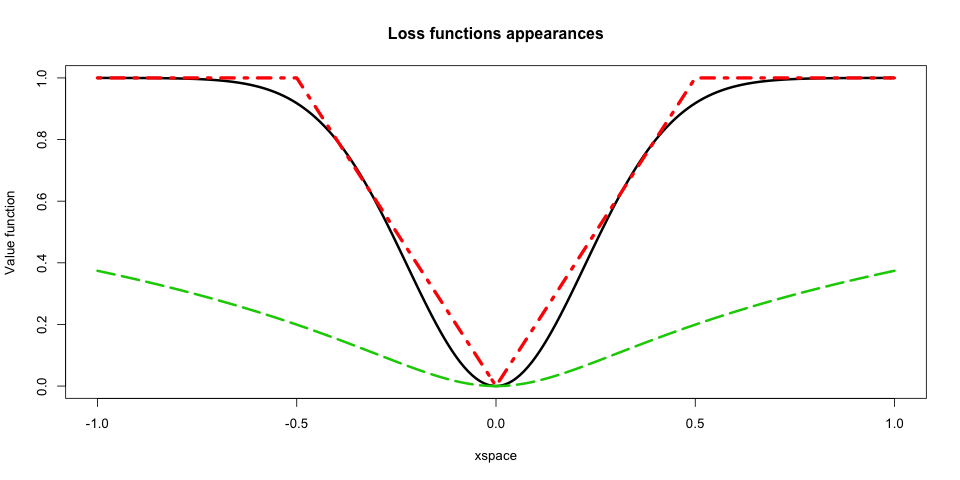

In [27]:
xspace <-  seq(-1, 1, 0.01)
# X11 ()
# pdf("~/yandexDisk/DIPLOMA/REPORTS/CoursePaper/imgs/loss_funcs.pdf", 12, 6)
# dev.copy(pdf, filname="~/yandexDisk/DIPLOMA/REPORTS/CoursePaper/imgs/loss_funcs.pdf", 12, 6)
plot(xspace, MeshalkinLoss(xspace, offset=0.5), type="l", lwd=3, main="Loss functions appearances", ylab="Value function")
lines(xspace, TriangularLoss(xspace, offset=5 * offset), type="l", col=2, lwd=4, lty=10 )
lines(xspace, CauchyLoss(xspace, c = offset * 3), type="l", col=3, lwd=3, lty=5 )
# plot(xspace, MeshalkinGain.grad (xspace, offset=offset), type="l")
# plot(xspace, MeshalkinGain.hess(xspace, offset=offset), type="l")
# dev.off()

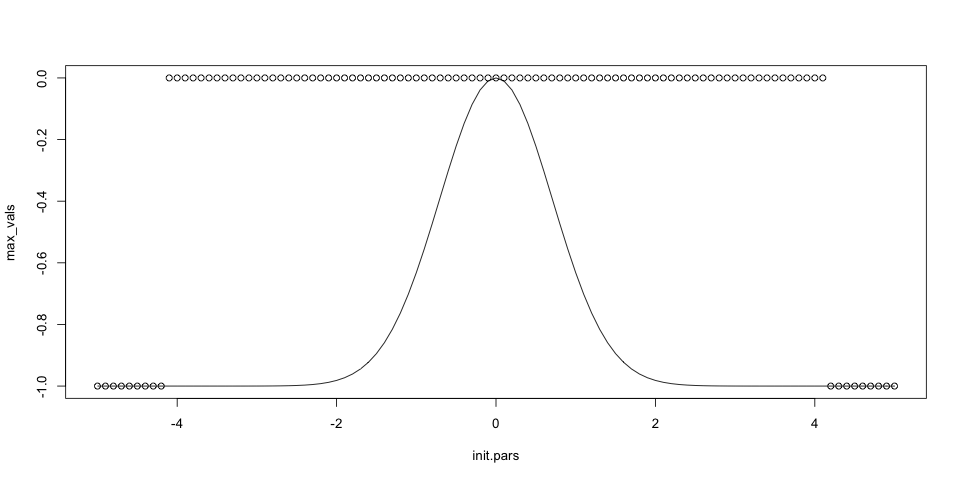

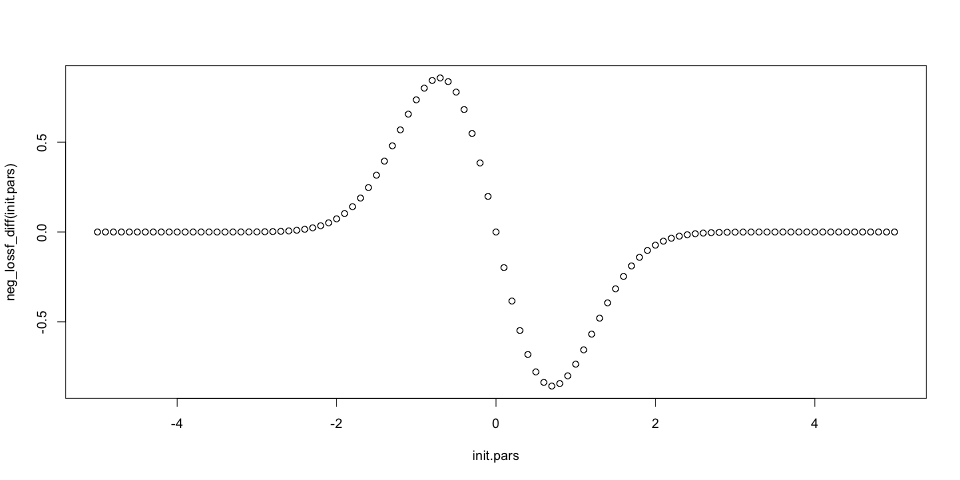

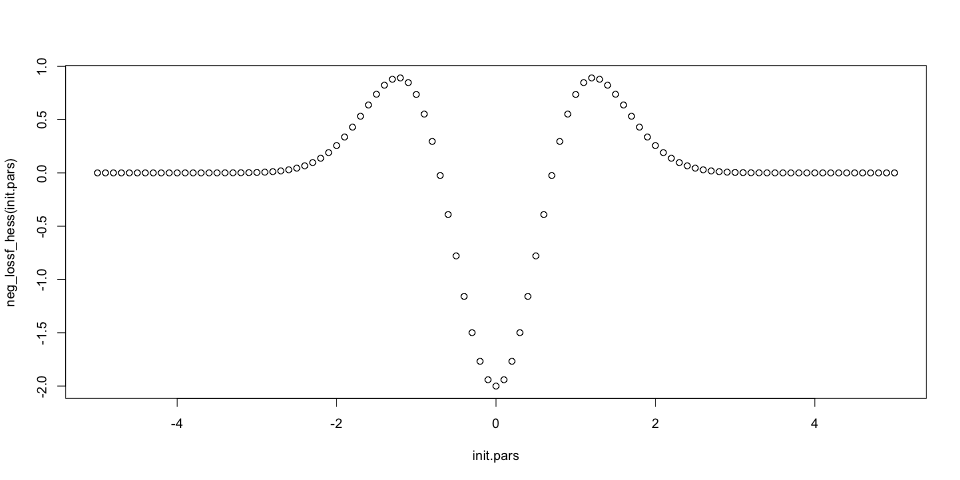

In [13]:
lossf <- function(u, offset=1) {
  return (1 - exp(-u**2 / offset))
}
lossf_diff <- function(u, offset=1) {
  return (2 * u / offset * exp(-u**2 / offset))
}
lossf_hess <- function(u, offset=1) {
  return (2 / offset * exp(-u**2 / offset) * (1 - 2 * u ** 2 / offset))
}

neg_lossf <- function(p) {- lossf(p)} 
neg_lossf_diff <- function(p) {- lossf_diff(p)} 
neg_lossf_hess <- function(p) {- lossf_hess(p)} 

init.pars <- seq(-5, 5, 0.1)
max_vals <- sapply(init.pars, function(p) (maxNR(neg_lossf, grad=neg_lossf_diff, 
#                                                  hess=neg_lossf_hess,  
                                                 start=p)$maximum))
plot(init.pars, max_vals)
lines(init.pars, neg_lossf(init.pars), type="l")
plot(init.pars, neg_lossf_diff(init.pars))
plot(init.pars, neg_lossf_hess(init.pars))

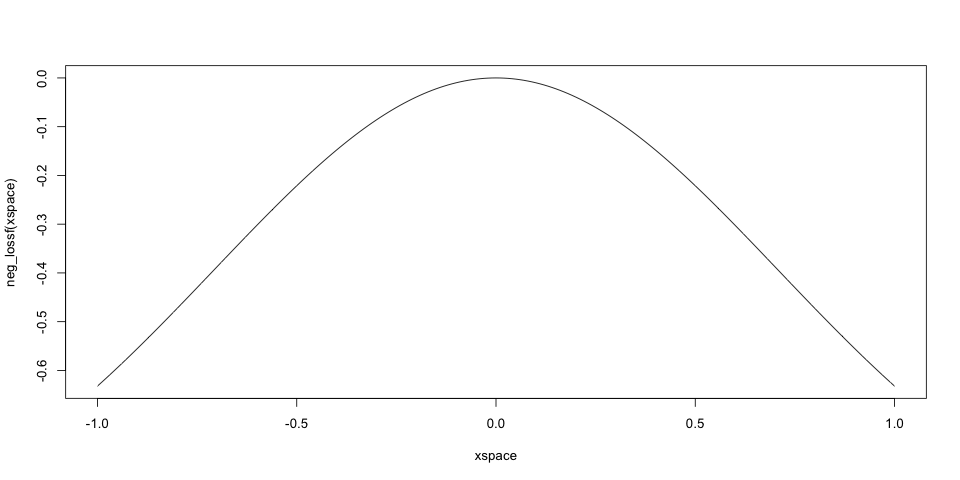

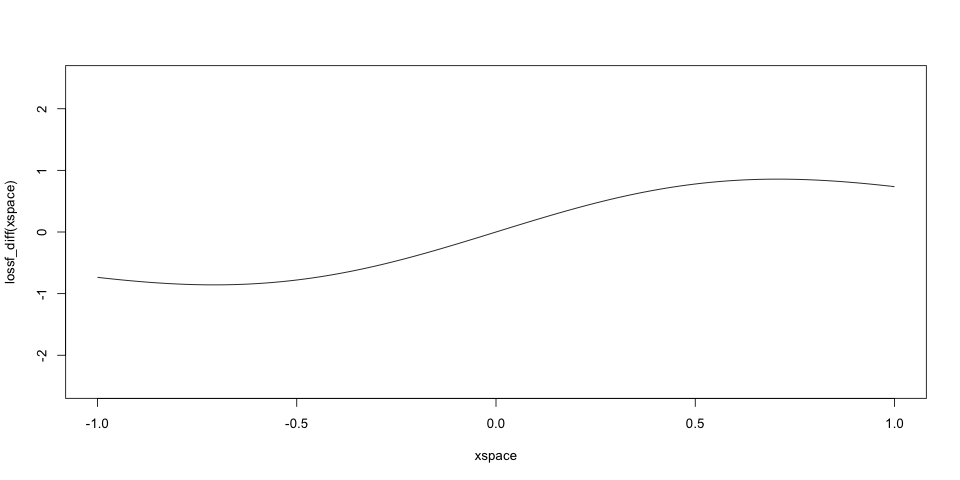

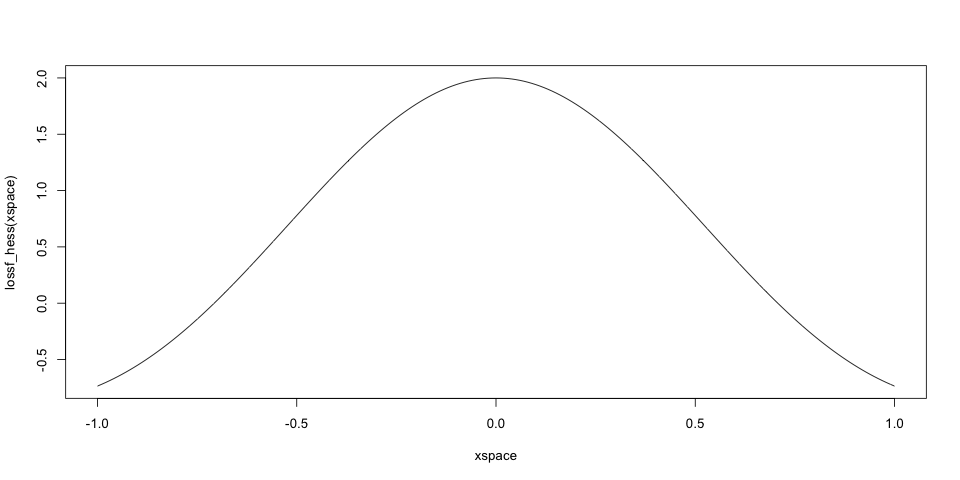

In [14]:


plot(xspace, neg_lossf(xspace), type="l")
plot(xspace, lossf_diff(xspace), type="l", ylim=c(-2.5,2.5))
plot(xspace, lossf_hess(xspace), type="l")



In [15]:
GetOwlParams <- function (data, lambda, weights=F, q = 0.6, t = 0.5) {
    constant = min(quantile(data$raw.reward, q), 0)
    data$weight = data$raw.reward - constant
    index = which(data$raw.reward > quantile(data$raw.reward, q))
    if (weights) {
         rqmodel = rq.with.weights(data$treatment[index] ~ data$covariates[index, ] - 1, tau = t, 
                                   method = "lasso", weights = data$weight[index], lambda = lambda)
    } else {
         rqmodel = rq(data$treatment[index] ~ data$covariates[index, ] - 1, tau = t, method = "lasso", 
                      weights = data$weight[index], lambda = lambda)
    }
    coefs = coef(rqmodel)
    return(matrix(coefs))
}

In [16]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)
pars.owl <- GetOwlParams(train, lambda, q = 0.6, 0.5) 

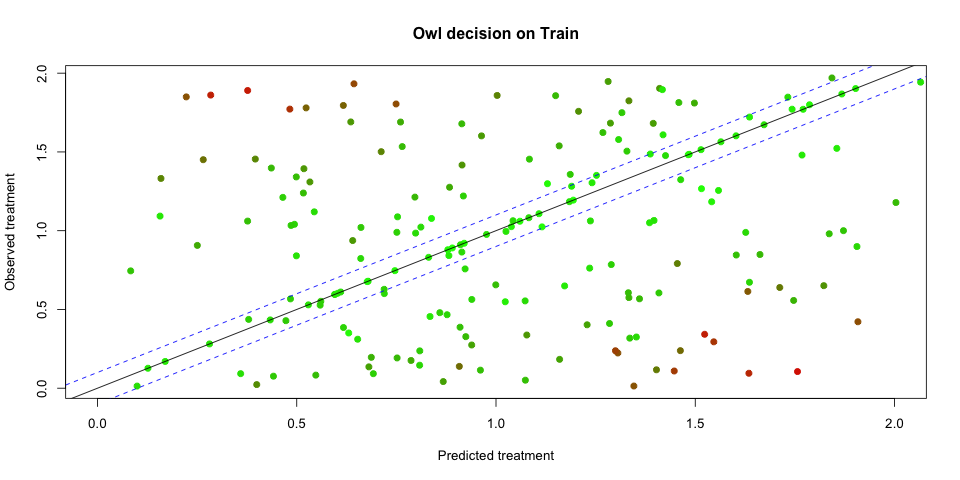

In [17]:
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on Train")

# Cauchy function loss

In [18]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)
pars.owl <- GetOwlParams(train, lambda, q = 0.6, 0.5) 

С увеличением $c$ функция ошибки становится все больше похожа на квадратичную (в определенном интервале). На самом деле при изменении $c$ меняется только масштаб. 

In [19]:
MeshalkinLoss <- function(u, offset=1) {
    offset = offset / 5
    return  (1 - exp(-u**2 / offset ))
}
MeshalkinLoss.grad  <- function(u, offset=1) {
    offset = offset / 5
    return (2 * u / offset * exp(-u**2 / offset))
}
MeshalkinLoss.hess <- function(u, offset=1) {
    offset = offset / 5
    return (2 / offset * exp(-u**2 / offset) * (1 - 2 * u ** 2 / offset))
}

# WARN: Using only 
# TODO: Decide what to use here: reward or raw reward ? 
MeshalkinObjFunc <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- MeshalkinLoss(deviance, offset = offset)
    return(mean(obs.data$reward * loss / obs.data$prop.scores / offset)  + lambda_reg * params %*% params )
}

MeshalkinObjFunc.grad <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- MeshalkinLoss.grad(deviance, offset = offset)
    obj.func.coefs <- obs.data$reward * loss / obs.data$prop.scores / offset 
    obj.func.value <-  colMeans(Diagonal(n=NROW(obj.func.coefs), x=obj.func.coefs) %*% (-obs.data$covariates))
    return(obj.func.value  + 2 * lambda_reg * params)
}


MeshalkinObjFunc.hess <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- MeshalkinLoss.hess(deviance, offset = offset)
    obj.func.matrix <- obs.data$reward * loss / obs.data$prop.scores / offset
    n <- length(obs.data$reward)
    acc <- 0 
    for (i in seq(1, n)) {
        acc <- acc + obj.func.matrix[i] * obs.data$covariates[i, ] %o% obs.data$covariates[i, ] 
    }
    return(acc / n  + 2 * lambda_reg * diag(NCOL(obs.data$covariates)))
}

MeshalkinObjFunc.2max <- function(...) {- MeshalkinObjFunc(...)}
MeshalkinObjFunc.grad.2max <- function(...) {- MeshalkinObjFunc.grad(...)}
MeshalkinObjFunc.hess.2max <- function(...) {- MeshalkinObjFunc.hess(...)}


NROptimize <- function (params, obs.data,  offset, policy.function, lambda, 
                                   hyperparams=list(), opt.hyperparams=list()) {
    default.list <- list(use.hessian=TRUE)
    opt.hyperparams <- modifyList(default.list, opt.hyperparams)
    if (opt.hyperparams$use.hessian) {
        res <- maxNR(MeshalkinObjFunc.2max, grad=MeshalkinObjFunc.grad.2max, start=opt.hyperparams$init.pars, 
                     obs.data=train,  offset=offset, policy.function=policy.function, lambda_reg=lambda) 
    } else {
        res <- maxNR(MeshalkinObjFunc.2max, grad=MeshalkinObjFunc.grad.2max, hess=MeshalkinObjFunc.hess.2max, 
                     start=opt.hyperparams$init.pars, 
                     obs.data=train,  offset=offset, policy.function=policy.function, lambda_reg=lambda) 
    }
    cat("Code: ", res$code, " Message: ", res$message, "\n")
    return (res$estimate)
} 


In [20]:
CauchyLoss <- function(u, c=1) {
    return (c / 2 * log(1  + (u / c) ^ 2)) 
}    

CauchyLoss.grad <- function(u, c=1) {
    return (u  /  (1 + (u / c) ^ 2))
}    

CauchyLoss.hess <- function(u, c=1) {
  return  ((1 - (u / c) ^ 2)  /  (1 + (u / c)^2)^2)
}  

# WARN: Using only 
# TODO: Decide what to use here: reward or raw reward ? 
CauchyObjFunc <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- CauchyLoss(deviance, offset = offset)
    return(mean(obs.data$reward * loss / obs.data$prop.scores / offset)  + lambda_reg * params %*% params )
}

CauchyObjFunc.grad <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- CauchyLoss.grad(deviance, offset = offset)
    obj.func.coefs <- obs.data$reward * loss / obs.data$prop.scores / offset 
    obj.func.value <-  colMeans(
        Diagonal(n=NROW(obj.func.coefs), x=obj.func.coefs) %*% (-obs.data$covariates)
    )
    return(obj.func.value  + 2 * lambda_reg * params)
}


CauchyObjFunc.hess <- function(params, obs.data,  offset, policy.function, lambda_reg, hyperparams=list()) { 
    prediction <- policy.function(params, obs.data$covariates, hyperparams)
    deviance <- obs.data$treatment - prediction
    loss <- CauchyLoss.hess(deviance, offset = offset)
    obj.func.matrix <- obs.data$reward * loss / obs.data$prop.scores / offset
    n <- length(obs.data$reward)
    acc <- 0 
    for (i in seq(1, n)) {
        acc <- acc + obj.func.matrix[i] * obs.data$covariates[i, ] %o% obs.data$covariates[i, ] 
    }
    return(acc / n  + 2 * lambda_reg * diag(NCOL(obs.data$covariates)))
}


CauchyObjFunc.2max <- function(...) {- CauchyObjFunc(...)}
CauchyObjFunc.grad.2max <- function(...) {- CauchyObjFunc.grad(...)}
CauchyObjFunc.hess.2max <- function(...) {- CauchyObjFunc.hess(...)}

In [21]:
a  = list("ba"=c(1,2), "ds"=c(3,4), "gd"=c(5,6))
unlist(a)
# t(as.matrix(a))

ba1 ba2 ds1 ds2 gd1 gd2 
  1   2   3   4   5   6

In [22]:
xspace <- seq(-10, 10, length.out = 1000)
c = seq(0.1, 10, length.out = 20)      
plot(xspace, CauchyGain(xspace, tail(c, 1)), type="l")
for (ci  in c) {
  lines(xspace, CauchyGain(xspace, ci))
}

ERROR: Error in plot(xspace, CauchyGain(xspace, tail(c, 1)), type = "l"): error in evaluating the argument 'y' in selecting a method for function 'plot': Error: could not find function "CauchyGain"



ERROR: Error in xy.coords(x, y): could not find function "CauchyGain"


In [23]:
maxNR(neg_lossf, 
      grad=neg_lossf_diff, 
      hess=neg_lossf_hess,
      start=10)

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[7]]) result is length 0


$maximum
[1] -1

$estimate
[1] 10

$gradient
[1] -7.440152e-43

$hessian
            [,1]
[1,] 1.48059e-41

$code
[1] 1

$message
[1] "gradient close to zero"

$last.step
NULL

$fixed
[1] FALSE

$iterations
[1] 1

$type
[1] "Newton-Raphson maximisation"

$control
A 'MaxControl' object with slots:
tol = 1e-08 
reltol = 1.490116e-08 
gradtol = 1e-06 
steptol = 1e-10 
lambdatol = 1e-06 
qrtol = 1e-10 
qac = stephalving 
marquardt_lambda0 = 0.01 
marquardt_lambdaStep = 2 
marquardt_maxLambda = 1e+12 
nm_alpha = 1 
nm_beta = 0.5 
nm_gamma = 2 
sann_cand = <default Gaussian Markov kernel>
sann_temp = 10 
sann_tmax = 10 
sann_randomSeed = 123 
iterlim = 150 
printLevel = 0 

attr(,"class")
[1] "maxim" "list" 

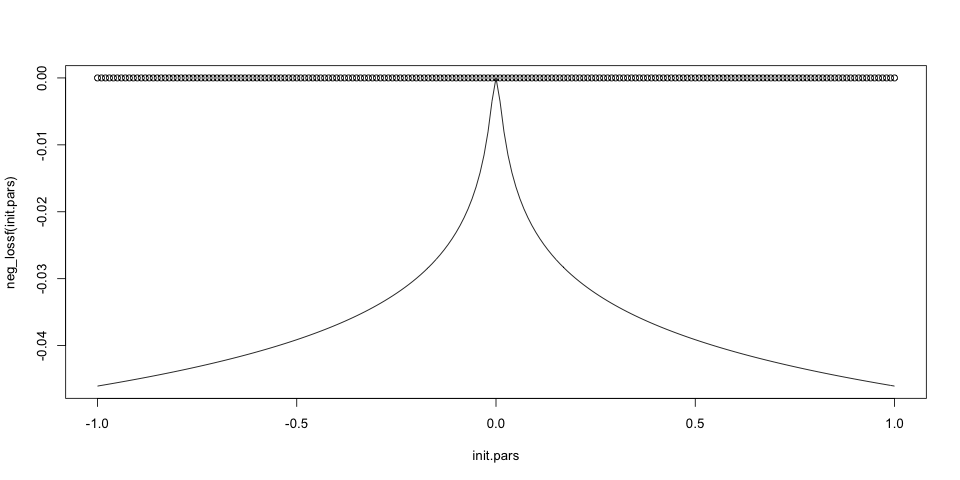

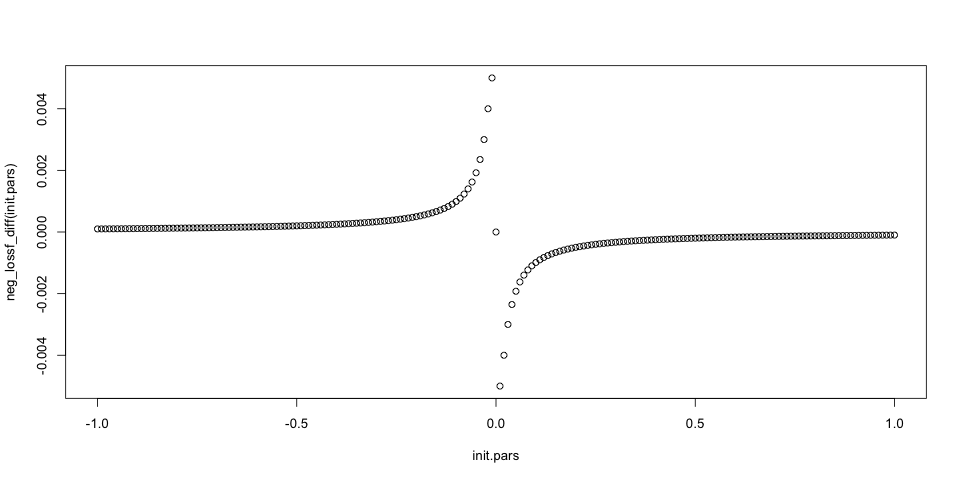

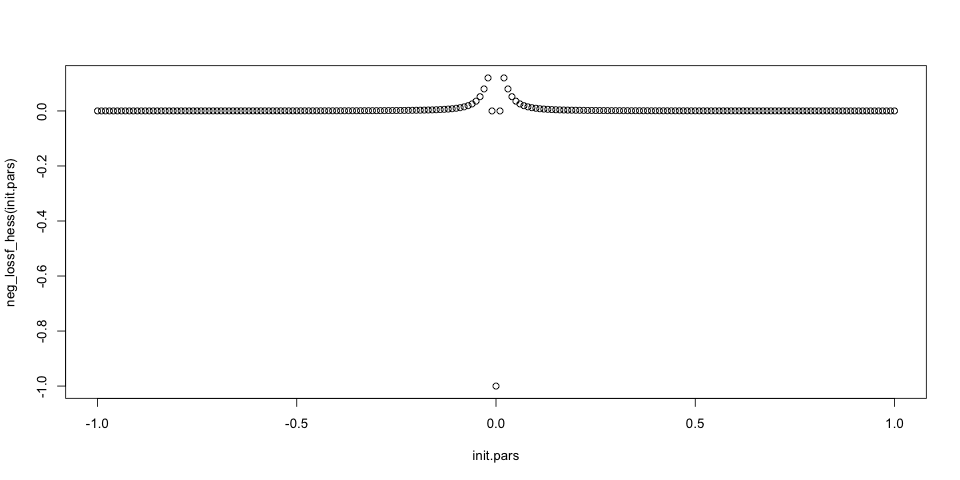

In [24]:
c = 0.01
neg_lossf <- function(u) {- CauchyLoss(u, c)} 
neg_lossf_diff <- function(u) {- CauchyLoss.grad(u, c)} 
neg_lossf_hess <- function(u) {- CauchyLoss.hess(u, c)} 

init.pars <- seq(-1, 1, 0.01)
max_vals <- sapply(init.pars, function(p) (maxNR(neg_lossf, grad=neg_lossf_diff, 
                                                 hess=NULL,  
                                                 start=p)$maximum))
plot(init.pars, neg_lossf(init.pars), type="l")
points(init.pars, max_vals)
plot(init.pars, neg_lossf_diff(init.pars))
plot(init.pars, neg_lossf_hess(init.pars))

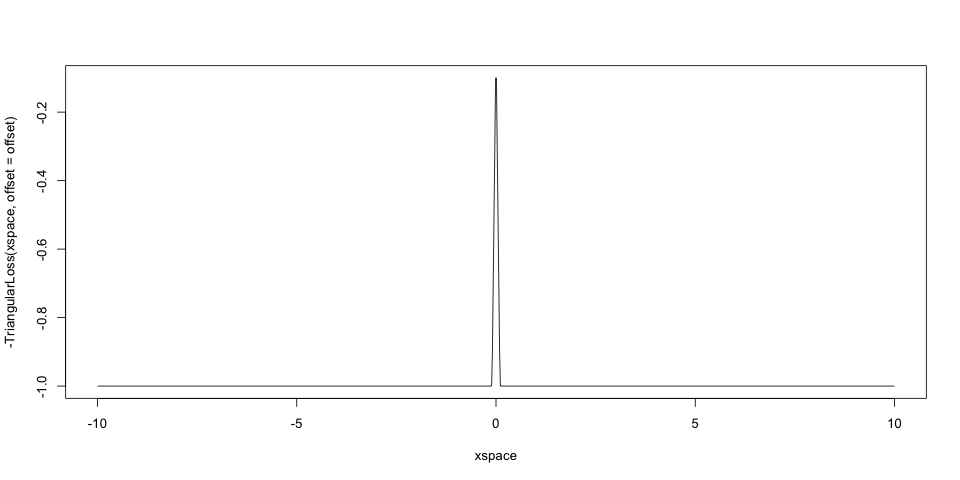

In [25]:
plot(xspace, - TriangularLoss(xspace, offset=offset), type="l")

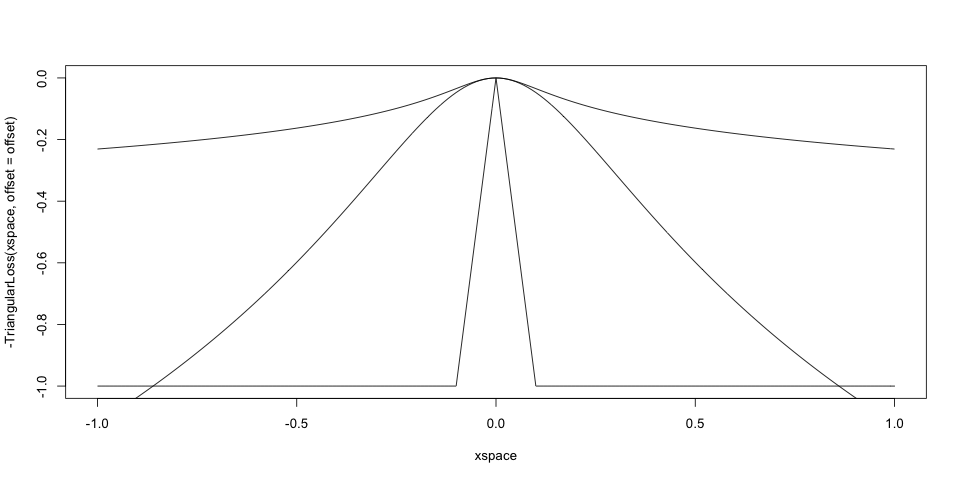

In [26]:
offset=0.1
const = 3
xspace <-  seq(-1, 1, 0.01)
plot(xspace, - TriangularLoss(xspace, offset=offset), type="l")
lines(xspace, - CauchyLoss(xspace, offset), type="l")
lines(xspace, - const * CauchyLoss(xspace, const  * offset), type="l")
# plot(xspace, MeshalkinLoss.grad(xspace, offset=offset), type="l")
# plot(xspace, MeshalkinLoss.hess(xspace, offset=offset), type="l")

# Bad value function illustration

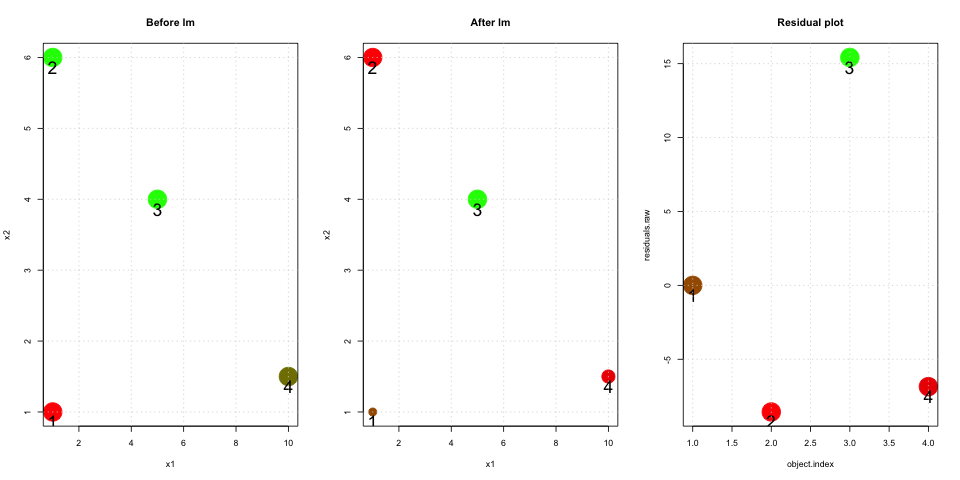

In [27]:
data <- list()
object.index = 1:4
data$X <- as.matrix(data.frame(intercept=rep(1,4), x1=c(1, 1, 5, 10), x2=c(1, 6, 4, 1.5)))
data$R <- as.matrix(data.frame(a1=c(0, 49, 101, 0), a0=c(101, 100, 0, 50)))
R.index <- c(1, 2 , 1, 2)
R.observed <- data$R[cbind(object.index, R.index)]
R.observed.01.scaled <- ScaleToZeroOne(R.observed)
par(mfrow = c(1,3))
plot(data$X[, 2:3], col=rgb(1 - R.observed.01.scaled, R.observed.01.scaled ,  0), pch=20, cex=7, main="Before lm")
text(data$X[, 2:3], labels=object.index, cex=2, pos=1)
grid()
lmmodel <- lm(R.observed ~ data$X -1)
w <- coef(lmmodel)
residuals.raw <- resid(lmmodel)
residuals <- ScaleToZeroOne(residuals.raw)
plot(data$X[, 2:3], col=rgb(1 - residuals, residuals,  0), pch=20, cex=4 * ScaleToZeroOne(R.observed)+3,  main="After lm")
text(data$X[, 2:3], labels=object.index, cex=2, pos=1)
grid()
plot(object.index, residuals.raw , col=rgb(1 - residuals, residuals,  0),  pch=20, cex=7,  main="Residual plot")
text(object.index, residuals.raw , labels=object.index, cex=2, pos=1)
# text(object.index, residuals.raw , labels=object.index, cex=2, pos=1)
grid()

Интересно, что получается, что 2 объект, который лечили почти идеально перешел в ту категорию, в которой его лечение считается  плохим. 

Простая регрессия может быть плохой, потому что если в данных есть выбросы, то мы сильно зафитимся  на них

In [28]:
library(lattice)
library("plot3D")
g <-  cbind(rep(1, length(x1space)), expand.grid(x1 = seq(0, 10, 0.5), x2=seq(0, 6, 0.5)))
g$z <- as.matrix(grid.values) %*% w
wireframe(z ~ x1 * x2, data = g, aspect = c(1, 1, 0.5), 
          scales = list(arrows = FALSE),
              panel.3d.wireframe = function(x, y, z, ...) {
              panel.3dwire(x = x, y = y, z = z, ...)
          }, 
          drape = TRUE, colorkey = TRUE,
#           screen = list(z = 30, x = -60)
         )
# scatter3D(data$X[,2], data$X[,3], R.observed)

ERROR: Error in cbind(rep(1, length(x1space)), expand.grid(x1 = seq(0, 10, 0.5), : object 'x1space' not found


ERROR: Error in as.matrix(grid.values): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': Error: object 'grid.values' not found



ERROR: Error in wireframe.formula(z ~ x1 * x2, data = g, aspect = c(1, 1, 0.5), : object 'g' not found
